# **CAPSTONE PROJECT** - PART 7 - MODELING

By Chau Tran

## TABLE OF CONTENTS<a id="top7"></a>

* [Load libraries and data](#data7)
* [Features encoding](#features)
* [Modelling](#modelling)
* [Cross validation and evaluation](#crossValidation)
* [An attempt on Deel learning](#deepLearning)
* [Hyperparameters tuning](#hypertuning)
* [Feature importance](#featureImportance)

### LOAD LIBRARIES AND DATA<a id="data7"></a>
[Back to top](#top7)

In [190]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance

import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier

from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, recall_score, precision_score, f1_score, average_precision_score 
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report
from sklearn.metrics import plot_precision_recall_curve, precision_recall_curve

from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout
from keras.utils import to_categorical

# sns.set(color_codes = True)

pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

%matplotlib inline

In [2]:
# load dataset

df_household_demo= pd.read_csv('DATA_CLEAN/households_withDemographic_beforeCamp18.csv')

In [3]:
df_household_demo.head()

,household_key,received_campaign,redeemed_coupons,TypeA,TypeB,TypeC,total_campaigns_received,total_campaigns_engaged,total_coupons_received,total_coupons_redeemed,camp_conversion_rate,coupon_conversion_rate,recency,frequency,monetary,rfm_group,rfm_score,segment,GROCERY_spend,DELI_spend,PRODUCE_spend,KIOSK-GAS_spend,DRUG GM_spend,NUTRITION_spend,SALAD BAR_spend,MEAT_spend,received_campA_18,redeemed_campA_18,zip_code,zipcode_segment,purchase_most_trans_time,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc
0,7,1,0,0.0,3.0,0.0,3.0,0.0,45.0,0.0,0.00,0.00,10,38,2320.50,223,7,Need attention,1184.37,116.15,168.34,0.00,497.99,4.98,0.00,175.52,1,0,40243,TopIncome,1804,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown
1,8,1,1,2.0,6.0,0.0,8.0,1.0,136.0,1.0,0.12,0.01,0,90,4113.90,434,11,Champions,2208.33,45.47,183.04,188.94,688.08,11.98,50.55,261.88,1,0,37211,HighIncome,2149,25-34,U,25-34K,Unknown,2 Adults Kids,3,1
2,13,1,1,2.0,4.0,0.0,6.0,11.0,82.0,11.0,1.83,0.13,0,207,10138.40,444,12,Champions,3692.39,47.65,232.49,2472.86,2187.85,3.31,10.09,19.13,1,1,62946,MediumIncome,823,25-34,U,75-99K,Homeowner,2 Adults Kids,4,2
3,16,1,0,1.0,1.0,0.0,2.0,0.0,32.0,0.0,0.00,0.00,4,92,1471.45,332,8,Need attention,785.67,97.87,86.97,192.30,68.29,8.86,6.43,95.79,0,0,40241,TopIncome,659,45-54,B,50-74K,Homeowner,Single Female,1,None/Unknown
4,17,1,0,4.0,0.0,0.0,4.0,0.0,64.0,0.0,0.00,0.00,1,114,4582.07,434,11,Champions,1682.07,37.36,208.75,683.13,820.86,10.97,0.00,909.34,1,0,40503,HighIncome,1718,65+,B,Under 15K,Homeowner,2 Adults No Kids,2,None/Unknown


### FEATURES ENCODING AND CORRELATION CHECKING<a id="features"></a>
[Back to top](#top7)

In [6]:
# get all numerical columns
numerical_dtypes = ['int16','int32', 'int64','float16','float32','float64']
num_cols = []
for i in df_household_demo.columns:
    if df_household_demo[i].dtype in numerical_dtypes:
        num_cols.append(i)
        
print(len(num_cols))
print(num_cols)

cat_cols = df_household_demo.columns.difference(num_cols)
print(len(cat_cols))
print(cat_cols)


29
['household_key', 'received_campaign', 'redeemed_coupons', 'TypeA', 'TypeB', 'TypeC', 'total_campaigns_received', 'total_campaigns_engaged', 'total_coupons_received', 'total_coupons_redeemed', 'camp_conversion_rate', 'coupon_conversion_rate', 'recency', 'frequency', 'monetary', 'rfm_group', 'rfm_score', 'GROCERY_spend', 'DELI_spend', 'PRODUCE_spend', 'KIOSK-GAS_spend', 'DRUG GM_spend', 'NUTRITION_spend', 'SALAD BAR_spend', 'MEAT_spend', 'received_campA_18', 'redeemed_campA_18', 'zip_code', 'purchase_most_trans_time']
9
Index(['age_desc', 'hh_comp_desc', 'homeowner_desc', 'household_size_desc', 'income_desc', 'kid_category_desc', 'marital_status_code', 'segment', 'zipcode_segment'], dtype='object')


In [7]:
df_household_demo.segment.unique()

array(['Need attention', 'Champions', 'Loyal', 'Required activation'],
      dtype=object)

In [8]:
# ENCODE CATEGORICAL ORDINAL COLS

def factorize_ordinal_cols(data,cols,cat_list):
    for i in cols: 
        new_col = i + '_rating'
        cat = pd.Categorical(data[i], 
                         categories=cat_list, 
                         ordered=True)
        labels, unique = pd.factorize(cat, sort=True)
        data[new_col] = labels
        

cat1_cols = ['homeowner_desc']
cat2_cols = ['income_desc']
cat3_cols = ['age_desc']
cat4_cols = ['marital_status_code']
cat5_cols = ['segment']

cat1_list = ['Unknown','Probable Renter','Probable Owner','Renter','Homeowner']       
cat2_list = ['Under 15K','15-24K','25-34K','35-49K','50-74K','75-99K','100-124K','125-149K','150-174K','175-199K','200-249K','250K+']       
cat3_list = ['19-24','25-34','35-44', '45-54','55-64','65+']
cat4_list = ['U','B','A']
cat5_list = ['Required activation','Need attention','Loyal','Champions']
    
factorize_ordinal_cols(df_household_demo,cat1_cols,cat1_list)
factorize_ordinal_cols(df_household_demo,cat2_cols,cat2_list)
factorize_ordinal_cols(df_household_demo,cat3_cols,cat3_list)
factorize_ordinal_cols(df_household_demo,cat4_cols,cat4_list)
factorize_ordinal_cols(df_household_demo,cat5_cols,cat5_list)

# print(labels, unique)
df_household_demo.head()

,household_key,received_campaign,redeemed_coupons,TypeA,TypeB,TypeC,total_campaigns_received,total_campaigns_engaged,total_coupons_received,total_coupons_redeemed,camp_conversion_rate,coupon_conversion_rate,recency,frequency,monetary,rfm_group,rfm_score,segment,GROCERY_spend,DELI_spend,PRODUCE_spend,KIOSK-GAS_spend,DRUG GM_spend,NUTRITION_spend,SALAD BAR_spend,MEAT_spend,received_campA_18,redeemed_campA_18,zip_code,zipcode_segment,purchase_most_trans_time,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,homeowner_desc_rating,income_desc_rating,age_desc_rating,marital_status_code_rating,segment_rating
0,7,1,0,0.0,3.0,0.0,3.0,0.0,45.0,0.0,0.00,0.00,10,38,2320.50,223,7,Need attention,1184.37,116.15,168.34,0.00,497.99,4.98,0.00,175.52,1,0,40243,TopIncome,1804,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,4,4,3,2,1
1,8,1,1,2.0,6.0,0.0,8.0,1.0,136.0,1.0,0.12,0.01,0,90,4113.90,434,11,Champions,2208.33,45.47,183.04,188.94,688.08,11.98,50.55,261.88,1,0,37211,HighIncome,2149,25-34,U,25-34K,Unknown,2 Adults Kids,3,1,0,2,1,0,3
2,13,1,1,2.0,4.0,0.0,6.0,11.0,82.0,11.0,1.83,0.13,0,207,10138.40,444,12,Champions,3692.39,47.65,232.49,2472.86,2187.85,3.31,10.09,19.13,1,1,62946,MediumIncome,823,25-34,U,75-99K,Homeowner,2 Adults Kids,4,2,4,5,1,0,3
3,16,1,0,1.0,1.0,0.0,2.0,0.0,32.0,0.0,0.00,0.00,4,92,1471.45,332,8,Need attention,785.67,97.87,86.97,192.30,68.29,8.86,6.43,95.79,0,0,40241,TopIncome,659,45-54,B,50-74K,Homeowner,Single Female,1,None/Unknown,4,4,3,1,1
4,17,1,0,4.0,0.0,0.0,4.0,0.0,64.0,0.0,0.00,0.00,1,114,4582.07,434,11,Champions,1682.07,37.36,208.75,683.13,820.86,10.97,0.00,909.34,1,0,40503,HighIncome,1718,65+,B,Under 15K,Homeowner,2 Adults No Kids,2,None/Unknown,4,0,5,1,3


In [10]:
df_household_demo_encoded = pd.get_dummies(data = df_household_demo, columns = cat_cols)
df_household_demo_encoded.head()

,household_key,received_campaign,redeemed_coupons,TypeA,TypeB,TypeC,total_campaigns_received,total_campaigns_engaged,total_coupons_received,total_coupons_redeemed,camp_conversion_rate,coupon_conversion_rate,recency,frequency,monetary,rfm_group,rfm_score,GROCERY_spend,DELI_spend,PRODUCE_spend,KIOSK-GAS_spend,DRUG GM_spend,NUTRITION_spend,SALAD BAR_spend,MEAT_spend,received_campA_18,redeemed_campA_18,zip_code,purchase_most_trans_time,homeowner_desc_rating,income_desc_rating,age_desc_rating,marital_status_code_rating,segment_rating,age_desc_19-24,age_desc_25-34,age_desc_35-44,age_desc_45-54,age_desc_55-64,age_desc_65+,hh_comp_desc_1 Adult Kids,hh_comp_desc_2 Adults Kids,hh_comp_desc_2 Adults No Kids,hh_comp_desc_Single Female,hh_comp_desc_Single Male,hh_comp_desc_Unknown,homeowner_desc_Homeowner,homeowner_desc_Probable Owner,homeowner_desc_Probable Renter,homeowner_desc_Renter,homeowner_desc_Unknown,household_size_desc_1,household_size_desc_2,household_size_desc_3,household_size_desc_4,household_size_desc_5+,income_desc_100-124K,income_desc_125-149K,income_desc_15-24K,income_desc_150-174K,income_desc_175-199K,income_desc_200-249K,income_desc_25-34K,income_desc_250K+,income_desc_35-49K,income_desc_50-74K,income_desc_75-99K,income_desc_Under 15K,kid_category_desc_1,kid_category_desc_2,kid_category_desc_3+,kid_category_desc_None/Unknown,marital_status_code_A,marital_status_code_B,marital_status_code_U,segment_Champions,segment_Loyal,segment_Need attention,segment_Required activation,zipcode_segment_HighIncome,zipcode_segment_LowIncome,zipcode_segment_MediumIncome,zipcode_segment_TopIncome
0,7,1,0,0.0,3.0,0.0,3.0,0.0,45.0,0.0,0.00,0.00,10,38,2320.50,223,7,1184.37,116.15,168.34,0.00,497.99,4.98,0.00,175.52,1,0,40243,1804,4,4,3,2,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,1
1,8,1,1,2.0,6.0,0.0,8.0,1.0,136.0,1.0,0.12,0.01,0,90,4113.90,434,11,2208.33,45.47,183.04,188.94,688.08,11.98,50.55,261.88,1,0,37211,2149,0,2,1,0,3,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,1,0,0,0
2,13,1,1,2.0,4.0,0.0,6.0,11.0,82.0,11.0,1.83,0.13,0,207,10138.40,444,12,3692.39,47.65,232.49,2472.86,2187.85,3.31,10.09,19.13,1,1,62946,823,4,5,1,0,3,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,0,1,0
3,16,1,0,1.0,1.0,0.0,2.0,0.0,32.0,0.0,0.00,0.00,4,92,1471.45,332,8,785.67,97.87,86.97,192.30,68.29,8.86,6.43,95.79,0,0,40241,659,4,4,3,1,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1
4,17,1,0,4.0,0.0,0.0,4.0,0.0,64.0,0.0,0.00,0.00,1,114,4582.07,434,11,1682.07,37.36,208.75,683.13,820.86,10.97,0.00,909.34,1,0,40503,1718,4,0,5,1,3,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,1,0,0,0,1,0,0,0


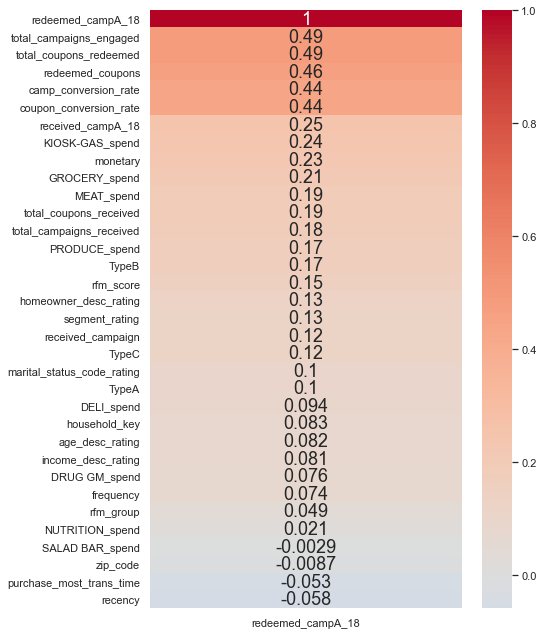

In [104]:
figure = plt.figure(figsize=(7,11))
sns.heatmap(df_household_demo.corr()[['redeemed_campA_18']].sort_values('redeemed_campA_18',ascending=False),annot=True, cmap='coolwarm', center=0);


In [109]:
demographic_cols = [
 'redeemed_campA_18',
 'segment_Champions',
 'segment_Loyal',
 'segment_Need attention',
 'segment_Required activation',
 'age_desc_19-24',
 'age_desc_25-34',
 'age_desc_35-44',
 'age_desc_45-54',
 'age_desc_55-64',
 'age_desc_65+',
 'hh_comp_desc_1 Adult Kids',
 'hh_comp_desc_2 Adults Kids',
 'hh_comp_desc_2 Adults No Kids',
 'hh_comp_desc_Single Female',
 'hh_comp_desc_Single Male',
 'homeowner_desc_Homeowner',
 'homeowner_desc_Renter',
 'household_size_desc_1',
 'household_size_desc_2',
 'household_size_desc_3',
 'household_size_desc_4',
 'household_size_desc_5+',
 'income_desc_100-124K',
 'income_desc_125-149K',
 'income_desc_15-24K',
 'income_desc_150-174K',
 'income_desc_175-199K',
 'income_desc_200-249K',
 'income_desc_25-34K',
 'income_desc_250K+',
 'income_desc_35-49K',
 'income_desc_50-74K',
 'income_desc_75-99K',
 'income_desc_Under 15K',
 'marital_status_code_A'
]

demographic_df = pd.DataFrame(df_household_demo_encoded, columns = test_cols)

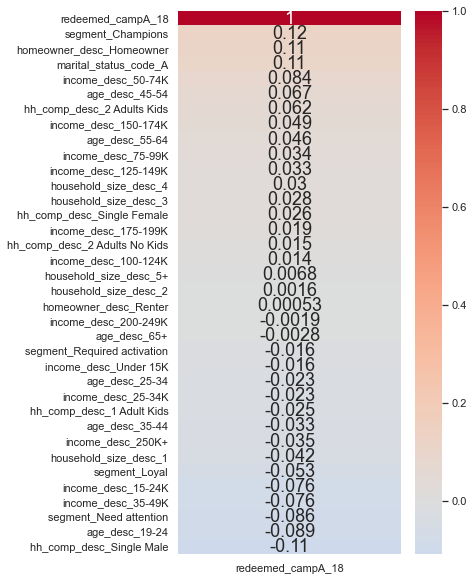

In [103]:

figure = plt.figure(figsize=(5,10))
sns.heatmap(demographic_df.corr()[['redeemed_campA_18']].sort_values('redeemed_campA_18',ascending=False),annot=True, cmap='coolwarm', center=0);


### MODELLING<a id="modelling"></a>
[Back to top](#top7)

In [11]:
# FUNCTION TO PLOT ROC CURVE AND DISPLAY SCORE

def plot_ROC_curve(model,X_test,y_test):

    # Generate the prediction values for each of the test observations using predict_proba() function rather than just predict
    preds = model.predict_proba(X_test)[:,1]

    # Store the false positive rate(fpr), true positive rate (tpr) in vectors for use in the graph
    fpr, tpr, _ = roc_curve(y_test, preds)

    # Store the Area Under the Curve (AUC) so we can annotate our graph with theis metric
    roc_auc = auc(fpr, tpr)

    # Plot the ROC Curve
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw = lw, label = 'ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color = 'navy', lw = lw, linestyle = '--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc = "lower right")
    plt.show()

def display_scores(model, X_test, y_test, y_pred):
    
    # predict probabilities
    pred_probs = model.predict_proba(X_test)
    # keep probabilities for the positive outcome only
    pred_probs = pred_probs[:, 1]
    
    print('Accuracy is: ',round(accuracy_score(y_test, y_pred),2))
    print('F1 score is: ',round(f1_score(y_test, y_pred),2))
    print('Ave PR score: ',round(average_precision_score(y_test, pred_probs),2))

    cm = confusion_matrix(y_test,y_pred)
    
    sns.heatmap(cm/np.sum(cm),annot=True,fmt='.2%', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    
    print(classification_report(y_test,y_pred))
    
    plot_precision_recall_curve(model, X_test, y_test)
    
    plot_ROC_curve(model,X_test,y_test)

In [12]:
df_household_demo_encoded[df_household_demo_encoded.redeemed_campA_18==1].shape[0]/df_household_demo_encoded[df_household_demo_encoded.redeemed_campA_18==0].shape[0]

0.265139116202946

In [113]:
# demographic_cols.remove('redeemed_campA_18')

X = pd.DataFrame(df_household_demo_encoded, columns = demographic_cols)

y = df_household_demo_encoded['redeemed_campA_18']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state=1, stratify=y, shuffle=True)
demographic_cols


['segment_Champions',
 'segment_Loyal',
 'segment_Need attention',
 'segment_Required activation',
 'age_desc_19-24',
 'age_desc_25-34',
 'age_desc_35-44',
 'age_desc_45-54',
 'age_desc_55-64',
 'age_desc_65+',
 'hh_comp_desc_1 Adult Kids',
 'hh_comp_desc_2 Adults Kids',
 'hh_comp_desc_2 Adults No Kids',
 'hh_comp_desc_Single Female',
 'hh_comp_desc_Single Male',
 'homeowner_desc_Homeowner',
 'homeowner_desc_Renter',
 'household_size_desc_1',
 'household_size_desc_2',
 'household_size_desc_3',
 'household_size_desc_4',
 'household_size_desc_5+',
 'income_desc_100-124K',
 'income_desc_125-149K',
 'income_desc_15-24K',
 'income_desc_150-174K',
 'income_desc_175-199K',
 'income_desc_200-249K',
 'income_desc_25-34K',
 'income_desc_250K+',
 'income_desc_35-49K',
 'income_desc_50-74K',
 'income_desc_75-99K',
 'income_desc_Under 15K',
 'marital_status_code_A']

In [114]:
# OVERSAMPLING DATA

from imblearn.over_sampling import SMOTE
from collections import Counter

smote = SMOTE(random_state = 42)
X_sm, y_sm = smote.fit_resample(X, y)

print(Counter(y_sm),Counter(y_test))

Counter({0: 611, 1: 611}) Counter({0: 245, 1: 65})


In [115]:
print(Xs_train.shape, ys_train.shape, Xs_test.shape, ys_test.shape)

(977, 35) (977,) (245, 35) (245,)


In [116]:
# STANDARDISE DATA

ss = StandardScaler()

Xs = ss.fit_transform(X_sm)

Xs_train, Xs_test, ys_train, ys_test = train_test_split(Xs,y_sm,test_size=0.2,random_state=42)


Accuracy is:  0.81
F1 score is:  0.79
Ave PR score:  0.88
              precision    recall  f1-score   support

           0       0.81      0.84      0.83       131
           1       0.81      0.78      0.79       114

    accuracy                           0.81       245
   macro avg       0.81      0.81      0.81       245
weighted avg       0.81      0.81      0.81       245



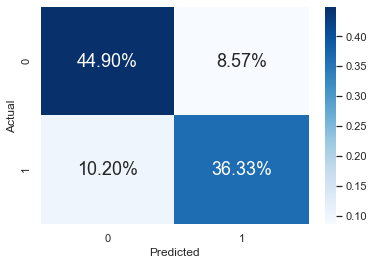

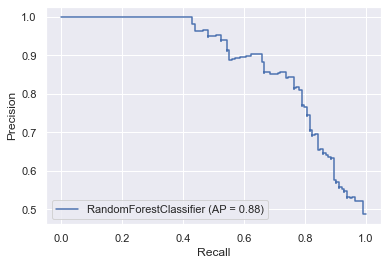

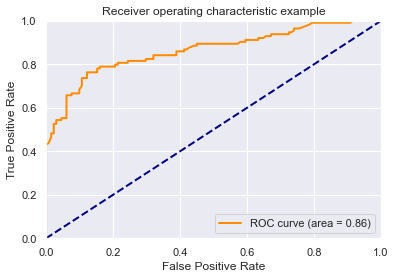

In [136]:
# CHECK WITH BASED SIMPLE MODEL
RF_clf = RandomForestClassifier()
    
RF_clf.fit(Xs_train,ys_train)

y_pred = RF_clf.predict(Xs_test)
display_scores(RF_clf, Xs_test, ys_test, y_pred)

### EVALUATE MODELS BY CROSS VALIDATION<a id="crossValidation"></a>
[Back to top](#top7)

In [207]:
def cross_val_models(X_train, X_test, y_train, y_test,imbalancedData=False,hyperTune=False):
    
    if not hyperTune:
        if imbalancedData:
            # models with hyperparams for imbalanced dataset
            models = [
                      ('LogReg', LogisticRegression(solver='liblinear')), 
                      ('RF', RandomForestClassifier(class_weight='balanced')),
                      ('GB', GradientBoostingClassifier()),
                      ('XGB', xgb.XGBClassifier(scale_pos_weight=5.2)),
                      ('KNN', KNeighborsClassifier()),
                      ('NB', GaussianNB())
                     ] 
        else:
             models = [
                      ('LogReg', LogisticRegression()), 
                      ('RF', RandomForestClassifier()),
                      ('GB', GradientBoostingClassifier()),
                      ('XGB', xgb.XGBClassifier()),
                      ('KNN', KNeighborsClassifier()),
                      ('NB', GaussianNB()),
                      ('Ada',AdaBoostClassifier())
                     ] 
            
    else: 
        XGB_clf = xgb.XGBClassifier(colsample_bytree=0.6,
                                     gamma=0.1,
                                     learning_rate= 0.1,
                                     max_depth=5,
                                     min_child_weight=1,
                                     n_estimators=100,
                                     subsample=0.8)
    
        
        RF_clf = RandomForestClassifier(max_depth=30,
                                         min_samples_leaf=1,
                                         min_samples_split=2,
                                         n_estimators=1200)
            
        GB_clf = GradientBoostingClassifier(random_state=42, 
                                            learning_rate=0.01, 
                                            max_depth=7, 
                                            n_estimators=500)
        log_model = LogisticRegression(solver='liblinear',
                                       C=100,
                                       penalty='l2')

        NB_clf = GaussianNB(var_smoothing = 1e-05)
        
        
        AdB_clf = AdaBoostClassifier(base_estimator= None, learning_rate=1, n_estimators=500)

    
        models = [
                  ('LogReg', log_model), 
                  ('RF', RF_clf),
                  ('GB', GB_clf),
                  ('XGB', XGB_clf),
                  ('NB', NB_clf),
                  ('AdB', AdB_clf)
                ] 
        
    
    scoring = ['accuracy', 'precision', 'recall', 'f1', 'average_precision','roc_auc']
    train_score_dfs = []
    test_score_dfs = []
    test_score_dict = {}
    target_names = ['No Redeem', 'Yes Redeem']
    for name, model in models:
        
        # GET TRAIN SCORES
        kfold = KFold(n_splits=5, shuffle=True, random_state=270)
        cv_results = cross_validate(model, X_train, y_train, cv=kfold, scoring=scoring)
        df1 = pd.DataFrame(cv_results)
        df1['model'] = name
        train_score_dfs.append(df1)
    
        # GET TEST SCORES
        clf = model.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        #print(name)
        #print(classification_report(y_test, y_pred, target_names=target_names))
        
        # predict probabilities
        pred_probs = model.predict_proba(X_test)
        # keep probabilities for the positive class only
        pred_probs = pred_probs[:, 1]
        
        test_score_dict = {'Accuracy': round(accuracy_score(y_test, y_pred),2),
                           'Precision': round(precision_score(y_test, y_pred),2),
                           'Recall': round(recall_score(y_test, y_pred),2),
                           'F1': round(f1_score(y_test, y_pred),2),
                           'Average PC': round(average_precision_score(y_test, pred_probs),2),
                           'ROC_AUC': round(roc_auc_score(y_test, y_pred),2)
                          }
        
        df2 = pd.DataFrame.from_dict(test_score_dict, orient='index').transpose()
        df2['Model'] = name
        test_score_dfs.append(df2)
    
    # combine all score sets into final df
    final_train_scores = pd.concat(train_score_dfs, ignore_index=True)
    final_test_scores = pd.concat(test_score_dfs, ignore_index=True)
    
    return final_train_scores, final_test_scores

In [157]:
# Cross validation without hyperparameter tunning

cv_scores1, test_scores1 = cross_val_models(Xs_train, Xs_test, ys_train, ys_test,imbalancedData=False) 

print('\n MEAN CV')
print(cv_scores1.groupby('model').mean().sort_values(['test_f1','test_accuracy'],ascending=False))
print('\n MEAN STD')
print(cv_scores1.groupby('model').std().sort_values(['test_f1','test_accuracy'],ascending=True))
print('\n TEST SCORE')
print(test_scores1.sort_values(['Accuracy'],ascending=False))

/Users/chautran/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:39:38] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/chautran/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:39:38] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/chautran/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:39:38] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/chautran/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:39:39] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/chautran/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:39:39] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/chautran/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:39:39] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
MEAN CV
        fit_time  score_time  test_accuracy  test_precision  test_recall   test_f1  test_average_precision  test_roc_auc
model                                                                                                                   
RF      0.329000    0.052450       0.839367        0.889018     0.782252  0.830795                0.901080      0.892410
XGB     0.258199    0.014154       0.820937        0.841592     0.798463  0.818950                0.917076      0.899122
NB      0.001601    0.007006       0.841392        1.000000     0.687673  0.814239                0.895125      0.836206
Ada     0.154757    0.049132       0.835212        0.961679     0.703925  0.812504                0.92321

In [203]:
# Compare models with cross validation + hyperparameter tunning

cv_scores2, test_scores2 = cross_val_models(Xs_train, Xs_test, ys_train, ys_test,imbalancedData=False,hyperTune=True)

print('\n MEAN CV')
print(cv_scores2.groupby('model').mean().sort_values(['test_f1','test_accuracy'],ascending=False))
print('\n MEAN STD')
print(cv_scores2.groupby('model').std().sort_values(['test_f1','test_accuracy'],ascending=True))
print('\n TEST SCORE')
print(test_scores2.sort_values(['Accuracy'],ascending=False))

/Users/chautran/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:41:27] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/chautran/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:41:28] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/chautran/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:41:28] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/chautran/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:41:29] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/chautran/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:41:30] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/chautran/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:41:30] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

 MEAN CV
        fit_time  score_time  test_accuracy  test_precision  test_recall   test_f1  test_average_precision  test_roc_auc
model                                                                                                                   
RF      3.649640    0.465780       0.837326        0.886056     0.780171  0.828242                0.918862      0.900231
GB      2.217576    0.015855       0.836285        0.917802     0.744016  0.821139                0.927964      0.899347
AdB     1.536167    0.291022       0.838289        0.949990     0.720052  0.818826                0.922222      0.885772
NB      0.002558    0.011090       0.841392        1.000000     0.687673  0.814239                0.894

In [161]:
cv_scores2.groupby('model').mean().sort_values(['test_f1','test_accuracy'],ascending=False)


,fit_time,score_time,test_accuracy,test_precision,test_recall,test_f1,test_average_precision,test_roc_auc
model,,,,,,,,
RF,2.213255,0.403467,0.843464,0.892913,0.786357,0.834848,0.918680,0.899849
GB,2.085378,0.015871,0.836285,0.917802,0.744016,0.821139,0.927964,0.899347
AdB,1.542209,0.318170,0.838289,0.949990,0.720052,0.818826,0.922222,0.885772
NB,0.002372,0.010041,0.841392,1.000000,0.687673,0.814239,0.894899,0.835681
LogReg,0.024551,0.010355,0.839330,0.989189,0.691858,0.813522,0.923017,0.884628
XGB,0.676167,0.015301,0.817881,0.888213,0.731603,0.801534,0.922065,0.899219


In [162]:
cv_scores2.groupby('model').std().sort_values(['test_f1','test_accuracy'],ascending=False)

,fit_time,score_time,test_accuracy,test_precision,test_recall,test_f1,test_average_precision,test_roc_auc
model,,,,,,,,
XGB,0.143973,0.002773,0.044800,0.034296,0.073994,0.056478,0.024906,0.033063
RF,0.416797,0.213465,0.035735,0.027203,0.071609,0.044328,0.026658,0.030728
GB,0.337825,0.003671,0.035737,0.041114,0.054757,0.043974,0.023600,0.032611
NB,0.000179,0.000251,0.021630,0.000000,0.046030,0.031971,0.014918,0.014823
LogReg,0.009181,0.002629,0.021353,0.024174,0.041375,0.028851,0.025165,0.038523
AdB,0.061232,0.060933,0.019289,0.024054,0.032246,0.023749,0.014364,0.021380


In [208]:
# Compare models with cross validation + hyperparameter tunning

cv_scores3, test_scores3 = cross_val_models(Xs_train, Xs_test, ys_train, ys_test,imbalancedData=False,hyperTune=True)

print('\n MEAN CV')
print(cv_scores3.groupby('model').mean().sort_values(['test_f1','test_accuracy'],ascending=False))
print('\n MEAN STD')
print(cv_scores3.groupby('model').std().sort_values(['test_f1','test_accuracy'],ascending=True))
print('\n TEST SCORE')
print(test_scores3.sort_values(['Accuracy'],ascending=False))

/Users/chautran/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/chautran/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:40:11] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:40:11] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/chautran/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/chautran/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:40:11] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:40:12] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/chautran/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/chautran/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:40:12] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:40:12] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

 MEAN CV
        fit_time  score_time  test_accuracy  test_precision  test_recall   test_f1  test_average_precision  test_roc_auc
model                                                                                                                   
RF      4.583797    0.573065       0.842439        0.892877     0.784233  0.833730                0.919765      0.900149
GB      2.343706    0.016050       0.836285        0.917802    

### AN ATTEMPT ON DEEP LEARNING USING KERAS<a id="deepLearning"></a>
[Back to top](#top7)

In [181]:
# Apply Keras deep learning model

def print_report(y_actual, y_predict):
    confusion = pd.DataFrame(confusion_matrix(y_actual, y_predict),
                             index=['actual_0', 'actual_1'],
                             columns=['predicted_0','predicted_1'])
    display(confusion)
    print(classification_report(y_actual, y_predict))

def run_keras(X_train, X_test, y_train, y_test, epochs=30, batch_size=10, optimizer='adam'):
    
    input_nodes = X_train.shape[1]

    model = Sequential()
    model.add(Input((input_nodes,)))
    model.add(Dense(16, activation="relu"))
    model.add(Dropout(0.3, seed=1))
    model.add(Dense(8, activation="relu"))
    model.add(Dropout(0.3, seed=2))
    model.add(Dense(2, activation='softmax'))
    
    # print model summary
    model.summary()
    
    # compile the model
    model.compile(optimizer=optimizer, 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

    history = model.fit(
        X_train,
        to_categorical(y_train),
        batch_size=batch_size,
        epochs=epochs,
        validation_split=.2,
        verbose=1,
    )
    print('-----------------------TRAIN----------------------')
    pred_train= model.predict(X_train)
    pred_train = [0 if x[0]>.5 else 1 for x in pred_train]
    print_report(y_train, pred_train)
    
    print('-----------------------TEST----------------------')
    pred_test= model.predict(X_test)
    pred_test = [0 if x[0]>.5 else 1 for x in pred_test]
    print_report(y_test, pred_test)

    return history.history, model

In [182]:
history, keras_clf = run_keras(Xs_train, Xs_test, ys_train, ys_test) 

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_45 (Dense)             (None, 16)                576       
_________________________________________________________________
dropout_24 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_46 (Dense)             (None, 8)                 136       
_________________________________________________________________
dropout_25 (Dropout)         (None, 8)                 0         
_________________________________________________________________
dense_47 (Dense)             (None, 2)                 18        
Total params: 730
Trainable params: 730
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
79/79 [==============================] - 1s 5ms/step - loss: 0.8554 - accuracy: 0.5647 - val_loss: 0.6604 - va

,predicted_0,predicted_1
actual_0,480,0
actual_1,157,340


              precision    recall  f1-score   support

           0       0.75      1.00      0.86       480
           1       1.00      0.68      0.81       497

    accuracy                           0.84       977
   macro avg       0.88      0.84      0.84       977
weighted avg       0.88      0.84      0.84       977

-----------------------TEST----------------------


,predicted_0,predicted_1
actual_0,131,0
actual_1,39,75


              precision    recall  f1-score   support

           0       0.77      1.00      0.87       131
           1       1.00      0.66      0.79       114

    accuracy                           0.84       245
   macro avg       0.89      0.83      0.83       245
weighted avg       0.88      0.84      0.83       245



In [183]:
hist = pd.DataFrame(history)
hist['epoch'] = hist.index+1
hist


,loss,accuracy,val_loss,val_accuracy,epoch
0,0.829223,0.597951,0.660365,0.724490,1
1,0.685345,0.642766,0.555341,0.790816,2
2,0.578174,0.717029,0.508992,0.806122,3
3,0.537636,0.751601,0.481575,0.806122,4
4,0.510213,0.775928,0.462491,0.806122,5
5,0.509538,0.787452,0.447430,0.806122,6
6,0.468793,0.797695,0.437078,0.811224,7
7,0.468446,0.802817,0.426472,0.811224,8
8,0.438609,0.813060,0.421537,0.811224,9
9,0.434228,0.822023,0.416237,0.811224,10


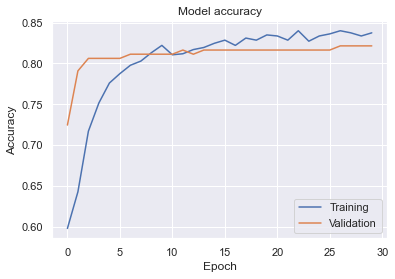

In [197]:
# Plot training & validation accuracy values
plt.plot(history['accuracy'], label = 'Training')
plt.plot(history['val_accuracy'], label = 'Validation')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

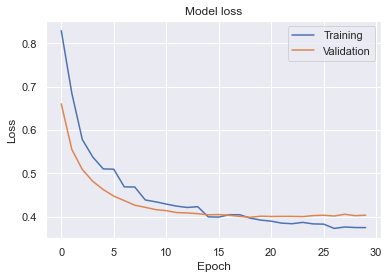

In [198]:
# Plot training & validation loss values
plt.plot(history['loss'], label = 'Training')
plt.plot(history['val_loss'], label = 'Validation')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

### HYPERPARAMETERS TUNING<a id="hypertuning"></a>
[Back to top](#top7)

In [33]:
# TUNING GAUSSIAN NAIVE BAYES 

NB_clf = GaussianNB()

params_NB = {'var_smoothing': np.logspace(0,-9, num=100)}

gs_NB = GridSearchCV(estimator=NB_clf, 
                 param_grid=params_NB, 
                 cv=5,   # use any cross validation technique 
                 verbose=1, 
                 scoring='precision') 
gs_NB.fit(Xs_train_sm,ys_train_sm)

gs_NB.best_params_

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    1.6s finished


{'var_smoothing': 1e-05}

In [54]:
# TUNING GRADIENT BOOSTING

param_grid = {
    "n_estimators":[5,50,100,250,500,600],
    "max_depth":[1,3,5,7,9],
    "learning_rate":[0.01,0.1,1,10,100]
}

# Create a based model
gb = GradientBoostingClassifier()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = gb, param_grid = param_grid,cv = 5, n_jobs = -1, verbose = 2, scoring='precision')
grid_search.fit(Xs_train_sm,ys_train_sm)
grid_search.best_params_

Fitting 5 folds for each of 150 candidates, totalling 750 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed: 10.3min finished


{'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 500}

In [251]:
# TUNING LOGISTIC REGRESSION

param_grid = {'penalty' : ['l1', 'l2'],
                'C' : [100, 10, 1.0, 0.1, 0.01],
                'solver' : ['newton-cg', 'lbfgs', 'liblinear']}


# Create a based model
lr = LogisticRegression()

kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = lr, param_grid = param_grid,cv = kfold, n_jobs = -1, verbose = 2, scoring='precision')
grid_result = grid_search.fit(Xs_train,ys_train)
grid_search.best_params_

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    1.0s finished


{'C': 0.01, 'penalty': 'l2', 'solver': 'newton-cg'}

In [89]:
# TUNING RANDOMFOREST SCORING RECALL

param_grid = {
    'max_depth': [5, 8, 15, 25, 30],
    'min_samples_leaf': [1, 2, 5, 10] ,
    'min_samples_split': [2, 5, 10, 15, 100],
    'n_estimators': [100, 300, 500, 800, 1200]
}

# Create a based model
RF = RandomForestClassifier()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = RF, param_grid = param_grid,cv = 5, n_jobs = -1, verbose = 1, scoring='recall')
grid_search.fit(Xs_train,ys_train)
grid_search.best_params_

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  9.4min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 15.0min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 24.4min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed: 35.8min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed: 48.8min
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed: 50.0min finished


{'max_depth': 30,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 800}

In [131]:
# TUNING RANDOMFOREST SCORING RECALL

param_grid = {
    'max_depth': [5, 8, 15, 25, 30],
    'min_samples_leaf': [1, 2, 5, 10] ,
    'min_samples_split': [2, 5, 10, 15, 100],
    'n_estimators': [100, 300, 500, 800, 1200]
}

# Create a based model
RF = RandomForestClassifier()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = RF, param_grid = param_grid,cv = 5, n_jobs = -1, verbose = 1, scoring='recall')
grid_search.fit(Xs_train,ys_train)
grid_search.best_params_

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   32.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 10.8min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 16.9min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed: 24.9min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed: 35.7min
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed: 36.6min finished


{'max_depth': 30,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 1200}

In [206]:
# TUNING XBG 

xgb_cfl = xgb.XGBClassifier(n_jobs = -1)

# A parameter grid for XGBoost
param_grid = {
        'n_estimators' : [100, 200],
        'learning_rate' : [0.01, 0.02, 0.05, 0.1, 0.25],
        'min_child_weight': [1, 5, 7, 10],
        'gamma': [0.1, 0.5, 1, 1.5, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5, 10, 12]
        }
grid_search = GridSearchCV(estimator = xgb_cfl, param_grid = param_grid,cv = 3, n_jobs = -1, verbose = 2)
grid_search.fit(Xs_train,ys_train)
grid_search.best_params_

Fitting 3 folds for each of 9000 candidates, totalling 27000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   33.7s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed:  9.3min
[Parallel(n_jobs=-1)]: Done 3273 tasks      | elapsed: 12.3min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed: 15.7min
[Parallel(n_jobs=-1)]: Done 4893 tasks      | elapsed: 19.3min
[Parallel(n_jobs=-1)]: Done 5824 tasks      | elapsed: 23.3min
[Parallel(n_jobs=-1)]: Done 6837 tasks      | elapsed: 27.9min
[Parallel(n_jobs=-1)]: Done 7930 tasks      | elapsed: 32.7min
[Parallel(n_jobs=-1)]: Done 9105 tasks      | 

[19:07:13] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


{'colsample_bytree': 0.6,
 'gamma': 0.1,
 'learning_rate': 0.1,
 'max_depth': 5,
 'min_child_weight': 1,
 'n_estimators': 100,
 'subsample': 0.8}

In [248]:
# TUNING AdaBoost 

AdB_cfl = AdaBoostClassifier()


param_grid =  {
            'n_estimators' : [50, 80, 100, 150, 200],
            'learning_rate': [.2, .5, 1, 2, 3],
#           'loss': ['linear', 'square', 'exponential'],
            'base_estimator': [None, DecisionTreeClassifier(max_depth=2),
                                    DecisionTreeClassifier(max_depth=4),
                                    DecisionTreeClassifier(max_depth=5)]
            }
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(estimator = AdB_cfl, param_grid = param_grid,cv = kfold, n_jobs = -1, verbose = 2, scoring='precision')
grid_search.fit(Xs_train,ys_train)
grid_search.best_params_            

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   28.0s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   60.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.4min finished


{'base_estimator': None, 'learning_rate': 1, 'n_estimators': 200}

In [147]:
# TUNING AdaBoost 

AdB_cfl = AdaBoostClassifier()


param_grid =  {
            'n_estimators' : [50, 80, 100, 150, 200],
            'learning_rate': [.2, .5, 1, 2, 3],
#           'loss': ['linear', 'square', 'exponential'],
            'base_estimator': [None, DecisionTreeClassifier(max_depth=2),
                                    DecisionTreeClassifier(max_depth=4),
                                    DecisionTreeClassifier(max_depth=5)]
            }
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(estimator = AdB_cfl, param_grid = param_grid,cv = kfold, n_jobs = -1, verbose = 2, scoring='recall')
grid_search.fit(Xs_train,ys_train)
grid_search.best_params_            

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   29.3s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.7min finished


{'base_estimator': DecisionTreeClassifier(max_depth=4),
 'learning_rate': 3,
 'n_estimators': 150}

### FEATURE IMPORTANCE ON BEST MODELS <a id="featureImportance"></a>
[Back to top](#top7)

Accuracy is:  0.82
F1 score is:  0.8
Ave PR score:  0.89
              precision    recall  f1-score   support

           0       0.81      0.86      0.84       131
           1       0.83      0.77      0.80       114

    accuracy                           0.82       245
   macro avg       0.82      0.82      0.82       245
weighted avg       0.82      0.82      0.82       245



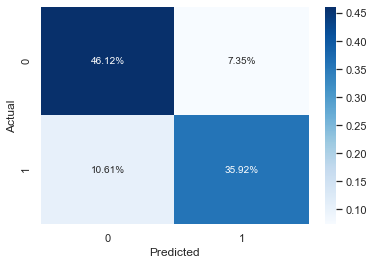

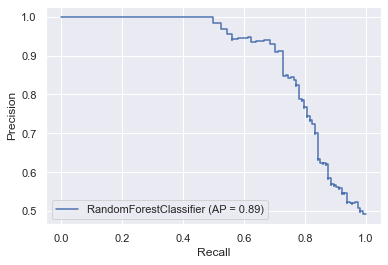

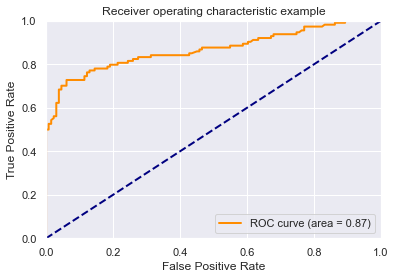

In [204]:
RF_clf = RandomForestClassifier(max_depth=30,
                                         min_samples_leaf=1,
                                         min_samples_split=2,
                                         n_estimators=1200)
    
RF_clf.fit(Xs_train,ys_train)
y_pred = RF_clf.predict(Xs_test)
display_scores(RF_clf, Xs_test, ys_test, y_pred)

                       feature     score
0            segment_Champions  0.047226
15    homeowner_desc_Homeowner  0.042382
30          income_desc_35-49K  0.037640
5               age_desc_25-34  0.035283
13  hh_comp_desc_Single Female  0.032399
31          income_desc_50-74K  0.031493
6               age_desc_35-44  0.028742
32          income_desc_75-99K  0.027482
34       marital_status_code_A  0.024558
8               age_desc_55-64  0.023619


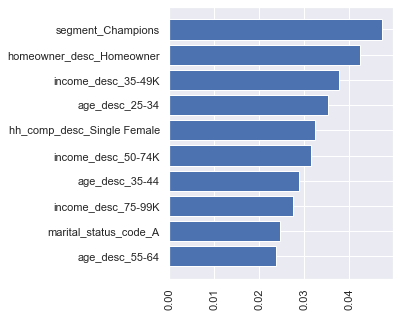

In [205]:
# calculate feature importance

per_imp = permutation_importance(RF_clf, Xs_train,ys_train, scoring='precision')
importances = per_imp.importances_mean
    
imp_dict = dict(zip(X.columns, importances))
score_df = pd.DataFrame(imp_dict.items(), columns=['feature', 'score'])
score_df = score_df.sort_values('score',ascending=False)
print(score_df.head(10))

# plot the scores
fig = plt.figure(figsize=(4,5))
score_df = score_df.sort_values('score',ascending=False).head(10).sort_values('score',ascending=True)
plt.barh(score_df.feature, score_df.score)
plt.xticks(rotation=90)
plt.show()


/Users/chautran/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:33:10] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy is:  0.82
F1 score is:  0.8
Ave PR score:  0.92
              precision    recall  f1-score   support

           0       0.82      0.85      0.84       131
           1       0.82      0.78      0.80       114

    accuracy                           0.82       245
   macro avg       0.82      0.82      0.82       245
weighted avg       0.82      0.82      0.82       245



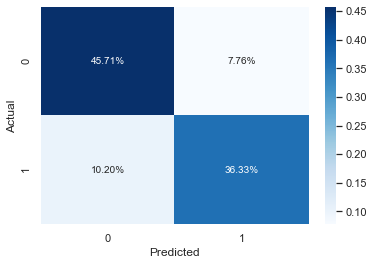

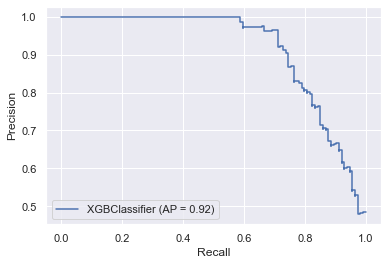

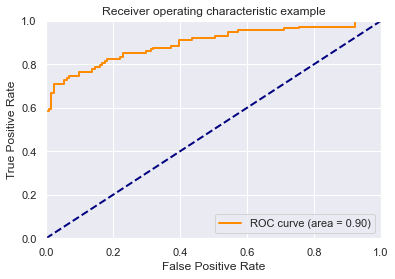

In [122]:
XGB_clf = xgb.XGBClassifier(colsample_bytree=0.6,
                             gamma=0.5,
                             learning_rate= 0.02,
                             max_depth=10,
                             min_child_weight=1,
                             n_estimators=200,
                             subsample=0.8)

XGB_clf.fit(Xs_train,ys_train)
y_pred = XGB_clf.predict(Xs_test)
display_scores(XGB_clf, Xs_test, ys_test, y_pred)

                     feature     score
35    total_coupons_received  0.121529
30        income_desc_35-49K  0.036217
6             age_desc_35-44  0.028169
5             age_desc_25-34  0.017706
14  hh_comp_desc_Single Male  0.016097
15  homeowner_desc_Homeowner  0.015694
17     household_size_desc_1  0.012072
34     marital_status_code_A  0.007646
2     segment_Need attention  0.007243
7             age_desc_45-54  0.006439


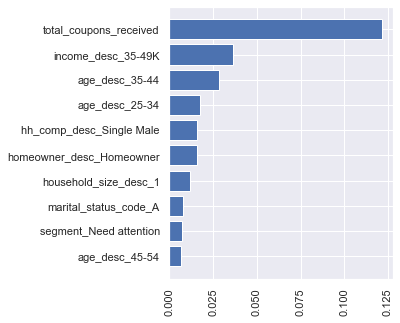

In [119]:
per_imp = permutation_importance(XGB_clf, Xs_train,ys_train, scoring='precision')
importances = per_imp.importances_mean
    
imp_dict = dict(zip(X.columns, importances))
score_df = pd.DataFrame(imp_dict.items(), columns=['feature', 'score'])
score_df = score_df.sort_values('score',ascending=False)
print(score_df.head(10))

# plot the scores
fig = plt.figure(figsize=(4,5))
score_df = score_df.sort_values('score',ascending=False).head(10).sort_values('score',ascending=True)
plt.barh(score_df.feature, score_df.score)
plt.xticks(rotation=90)
plt.show()


Accuracy is:  0.83
F1 score is:  0.8
Ave PR score:  0.9
              precision    recall  f1-score   support

           0       0.79      0.92      0.85       131
           1       0.89      0.72      0.80       114

    accuracy                           0.83       245
   macro avg       0.84      0.82      0.82       245
weighted avg       0.84      0.83      0.83       245



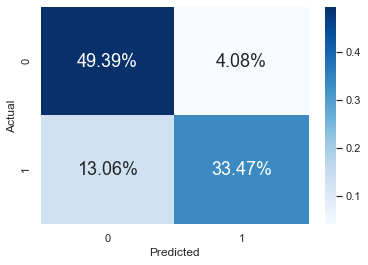

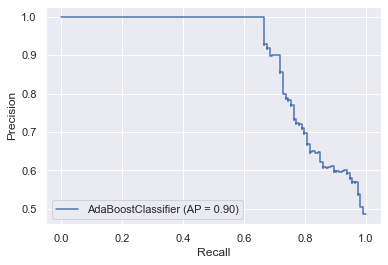

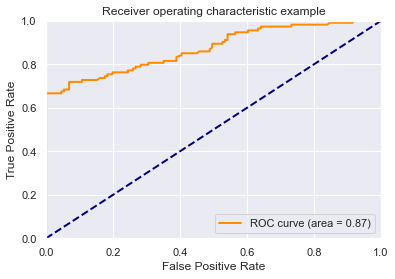

In [155]:
# AdB_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=2),
#                                      learning_rate=0.2,
#                                      n_estimators=80)
    
    
AdB_clf = AdaBoostClassifier(base_estimator= None, learning_rate=1, n_estimators=200)

AdB_clf.fit(Xs_train,ys_train)
y_pred = AdB_clf.predict(Xs_test)
display_scores(AdB_clf, Xs_test, ys_test, y_pred)

                          feature     score
13     hh_comp_desc_Single Female  0.066455
0               segment_Champions  0.051483
12  hh_comp_desc_2 Adults No Kids  0.045672
31             income_desc_50-74K  0.039878
5                  age_desc_25-34  0.039853
6                  age_desc_35-44  0.038722
30             income_desc_35-49K  0.036250
8                  age_desc_55-64  0.035785
15       homeowner_desc_Homeowner  0.035754
34          marital_status_code_A  0.032326


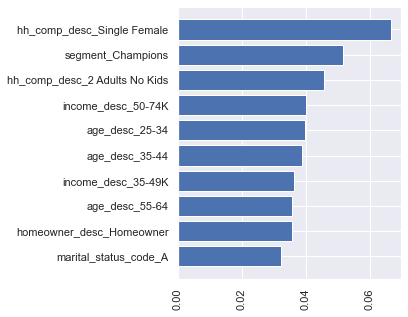

In [124]:
per_imp = permutation_importance(AdB_clf, Xs_train,ys_train, scoring='precision')
importances = per_imp.importances_mean
    
imp_dict = dict(zip(X.columns, importances))
score_df = pd.DataFrame(imp_dict.items(), columns=['feature', 'score'])
score_df = score_df.sort_values('score',ascending=False)
print(score_df.head(10))

# plot the scores
fig = plt.figure(figsize=(4,5))
score_df = score_df.sort_values('score',ascending=False).head(10).sort_values('score',ascending=True)
plt.barh(score_df.feature, score_df.score)
plt.xticks(rotation=90)
plt.show()
